In [1]:
from helpers import *

In [2]:
version='427080_Zprime_V5'
org_tracks ='nominal:pseudo:ideal:fakes_removed:fakes_removed_+_track_replaced:HF:HF_+_track_replaced'
workDir = '/Users/avalee/TrackingAnalysis/'

inDir = workDir + 'dataFrames/' 
outDir = workDir + 'plots/'

jetVars = getDataFrames(workDir, version, org_tracks, "jetVars")
tracks = org_tracks.split(':')

In [4]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
import os
import matplotlib.ticker as ticker
import matplotlib

if not (os.path.isdir(outDir)): os.makedirs(outDir)

In [10]:
def plotHisto(dataFrames, varName, xMin, xMax, xBins, varLabel, yLabel):
    figName = varName
    # Fetch histograms
    histoDict = fetchArrays(dataFrames, varName)
    
    # Plot histograms
    ax1, ax2 = configurePads(varName, varLabel, yLabel, xMin, xMax)
    yMaxs = []
    for histKey in histoDict.keys():
        label = histKey
        if '_+_' in label: label = label.replace('_+_', ', ')
        label = ' '.join(label.split('_'))
        y, x, _ = ax1.hist(histoDict[histKey], bins=xBins, range=(xMin,xMax), density=True, color=colourDict[histKey], histtype='step', label=label)
        yMaxs.append(y.max())
        
        # Get ratios
        histNom, bin_edges = np.histogram(histoDict["nominal"], bins=xBins, range=(xMin,xMax), density=True)
        hist, bin_edges = np.histogram(histoDict[histKey], bins=xBins, range=(xMin,xMax), density=True)
        ratio = getRatio(hist, histNom)
        
        # Plot ratios
        left,right = bin_edges[:-1],bin_edges[1:]
        X = np.array([left,right]).T.flatten()
        Y = np.array([ratio,ratio]).T.flatten()
        ax2.plot(X,Y, color=colourDict[histKey], linewidth=1)
    ax1.set_ylim([0, max(yMaxs)*1.35])
    
    # Draw a line for legend
    handles, labels = ax1.get_legend_handles_labels()
    new_handles = [Line2D([], [], c=h.get_edgecolor()) for h in handles]
    ax1.legend(labelspacing=0.3, bbox_to_anchor=(0.4, 0.5, 0.5, 0.5), loc='best', handles=new_handles, labels=labels, facecolor='none', edgecolor='none')
    
    plt.text(0.03, 0.93, "ATLAS Internal", fontsize=9, transform=ax1.transAxes, weight='bold', style='italic')
    
    plt.savefig(outDir + varName +".png", bbox_inches='tight', pad_inches=0.04)
    plt.savefig(outDir + varName+".pdf", bbox_inches='tight', pad_inches=0.04)
    
def plotAllHistos(varDict, dataFrames, yLabel="Arbitrary units"):
    for varName, varValues in varDict.items():
        xMin = varValues[0]
        xMax = varValues[1]
        xBins = varValues[2]
        varLabel = varValues[3]

        plotHisto(dataFrames, varName, xMin, xMax, xBins, varLabel, yLabel)


In [6]:
varTracksDict = {
        'jet_trk_nPixSCT': [0, 14, 14, 'Number of pixel and SCT hits'],
        #'jet_trk_nsharedPixSCT': [0, 10, 10, 'Number of shared pixels and SCT hits'],
        #'jet_trk_nPixHits': [0, 10, 10, 'Number of pixel hits'],
        #'jet_trk_nSCTHits': [0, 14, 14, 'Number of SCT hits'],
        #'jet_trk_nsharedPixHits': [0, 10, 10, "Number of shared pixels"],
        #'jet_trk_nsharedSCTHits': [0, 10, 10, "Number of shared SCT"],
        #'jet_trk_nsplitPixHits': [0, 10, 10, "Number of split pixels"],     
    
}

varJetsDict = {
        'jet_jf_n2t': [0, 11, 11, "No. of 2-track vertex candidates"],
        'jet_jf_m': [0, 10, 100, 'Invariant mass of tracks from displaced vertices [GeV]'],
        #'jet_jf_sig3d': [0, 30, 100, "Weighted flight length sig."],
        #'jet_jf_efc': ["0, 1, 100, 'Energy fraction'],
        #'jet_jf_nvtx1t': [0, 6, 6, "No. of displaced vertices with 1 track"],
        #'jet_jf_nvtx': ["0, 4, 4, "No. of displaced vertices with more than 1 track"],
        #'jet_jf_ntrkAtVx': [0, 11, 11, "No. of tracks from vertices with at least 2 tracks"],
        #'jet_jf_dR': [0, 0.2, 100, '#DeltaR between jet axis and all tracks with displaced vertices'],

}

colourDict = {
		'nominal': "#000000",
		'pseudo': "#17becf",
		'ideal': "#ff7f0e",
		'fakes_removed': "#2ca02c",
		'fakes_removed_+_track_replaced': "#d62728",
		'HF': "#9467bd",
		'HF_+_track_replaced': "#e377c2",
        'fake': "#bcbd22"
	}

#plotAllHistos(varJetsDict, jetVars)

In [175]:
def newDataFrames(dataFrames, varNames):
    new_dfs = collections.OrderedDict()
    for track in dataFrames.keys():
        new_df = dataFrames[track].filter(varNames, axis=1)
        new_dfs[track] = new_df
    return new_dfs

def getCutValues(jet_df, cutVarName, cutVarMax, outVarName, outVarCut, npoints):
    njets = len(jet_df.index)
    
    jet_values = []
    for i in range(npoints):
        x = cutVarMax/npoints
        cutValue = i*x
        jetCut_df = jet_df[(jet_df[cutVarName]>cutValue) & (jet_df[outVarName]>outVarCut)]
        jet_values.append(len(jetCut_df.index)/njets)
    
    return jet_values

def getROC(dataFrames, varNames, cutVarName, cutVarMax, outVarName, outVarCut, npoints):
    ROC_dfs = newDataFrames(dataFrames, varNames)
    ROC_values = collections.OrderedDict()
    for track in ROC_dfs.keys():
        track_df = ROC_dfs[track]

        jets = {"b": 5, "c": 4, "light": 0}
        for jet in jets.keys():
            jet_df = track_df[track_df['jet_LabDr_HadF']==jets[jet]]
            
            jet_values = getCutValues(jet_df, cutVarName, cutVarMax, outVarName, outVarCut, npoints)
            label = track + "_" + jet
            ROC_values[label] = jet_values
            
    return ROC_values

In [87]:
ROCVars = ['jet_jf_sig3d', 'jet_jf_nvtx', 'jet_LabDr_HadF']

In [88]:
ROCValues = getROC(jetVars, ROCVars, 'jet_jf_sig3d', 50, 'jet_jf_nvtx', 0, 50)


nominal_b
nominal_c
nominal_light
pseudo_b
pseudo_c
pseudo_light
ideal_b
ideal_c
ideal_light
fakes_removed_b
fakes_removed_c
fakes_removed_light
fakes_removed_+_track_replaced_b
fakes_removed_+_track_replaced_c
fakes_removed_+_track_replaced_light
HF_b
HF_c
HF_light
HF_+_track_replaced_b
HF_+_track_replaced_c
HF_+_track_replaced_light


In [239]:
def setStyle(width=600, height=550, label_size=9, my_dpi=100):
    plt.rcParams['pdf.fonttype'] = 42
    #plt.rcParams["font.family"] = "Helvetica"
    plt.rcParams['xtick.labelsize'] = label_size 
    plt.rcParams['ytick.labelsize'] = label_size 
    plt.rcParams['axes.labelsize'] = label_size 
    fig = plt.figure(figsize=(width/my_dpi, height/my_dpi), dpi=my_dpi)
    return fig

def configurePlots(jet1, jet2):
    fig = setStyle(500,400)
    ax = plt.subplot()
    
    ax.set_xlabel(r'$%s$-jet efficiency' %(jet1), horizontalalignment='right', x=1.0)
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    if jet2 == "c": ax.set_ylabel(r'$%s$-jet efficiency' %(jet1), horizontalalignment='right', x=1.0)
    else: ax.set_ylabel('%s-jet efficiency' %(jet2), horizontalalignment='right', y=1.0)
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
    
    return ax
        

In [247]:
def plotROCs(ROCValues, tracks, jet1, jet2):
    figName = "ROC_" + jet1 + jet2
    
    ax = configurePlots(jet1, jet2)

    for i in range(len(tracks)):
        key1 = tracks[i] + "_" + jet1 
        key2 = tracks[i] + "_" + jet2
        label = tracks[i]
        label = ' '.join(label.split('_'))
        plt.plot(ROCValues[key1], ROCValues[key2], color=colourDict[tracks[i]], label=label)
        
    plt.legend(bbox_to_anchor=[0.05, 0.6], loc='center left', labelspacing=0.3, facecolor='none', edgecolor='none')
    plt.text(0.03, 0.93, "ATLAS Internal", fontsize=9, transform=ax.transAxes, weight='bold', style='italic')
    
    
    plt.savefig(outDir + "/" + figName +".png", bbox_inches='tight', pad_inches=0.04)
    plt.savefig(outDir + "/" + figName +".pdf", bbox_inches='tight', pad_inches=0.04)
    

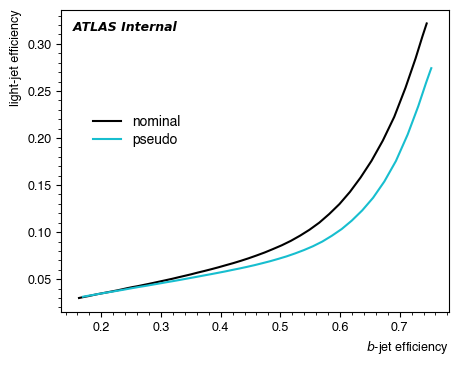

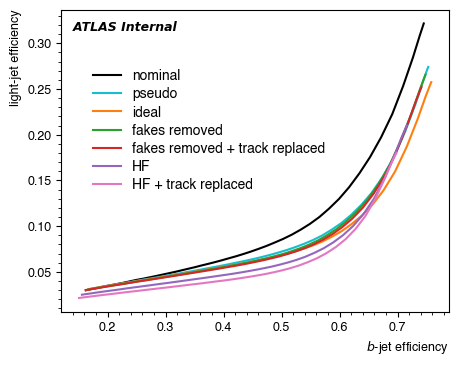

In [248]:
plotROCs(ROCValues, ["nominal", "pseudo"], "b", "light")
plotROCs(ROCValues, tracks, "b", "light")